In [39]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Load dataset
df_1 = pd.read_csv(r"C:\Users\may\Desktop\dataset\CEAS_08.csv")
df_2 = pd.read_csv(r"C:\Users\may\Desktop\dataset\data.csv")
df_3 = pd.read_csv(r"C:\Users\may\Desktop\dataset\balanced.csv")

# Extract relevant features and target
df_1 = df_1[['sender', 'subject', 'body', 'label']]
df_2 = df_2.rename(columns={'Email Text': 'body', 'Email Type': 'label'})
df_3 = df_3.rename(columns={'class': 'label'})

# Convert Email Type to boolean
df_2['label'] = df_2['label'].map({'Safe Email': 0, 'Phishing Email': 1})

# Remove empty values
df_1 = df_1.dropna(subset=['body', 'subject', 'label'])
df_2 = df_2.dropna(subset=['body'])
df_3 = df_3.dropna(subset=['body', 'label'])

# Add missing columns
df_2['sender'] = ''
df_2['subject'] = ''
df_3['sender'] = ''
df_3['subject'] = ''

# Combine datasets
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df = df[df['label'].isin([0, 1])]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#nltk.download('wordnet')
#stemmer = PorterStemmer()
#lemmatizer = WordNetLemmatizer()

# Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    #text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)
    #text = ' '.join(lemmatizer.lemmatize(word, pos='v') for word in text.split())  # Apply Lemmatization
    #text = ' '.join(stemmer.stem(word) for word in text.split()) # Apply Porter Stemming
    return text

df['cleaned_sender'] = df['sender'].apply(clean_text)
df['cleaned_subject'] = df['subject'].apply(clean_text)
df['cleaned_body'] = df['body'].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


multinomial Naive Bayes

Accuracy: 0.9583132142282311
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      6046
           1       0.99      0.93      0.96      6380

    accuracy                           0.96     12426
   macro avg       0.96      0.96      0.96     12426
weighted avg       0.96      0.96      0.96     12426



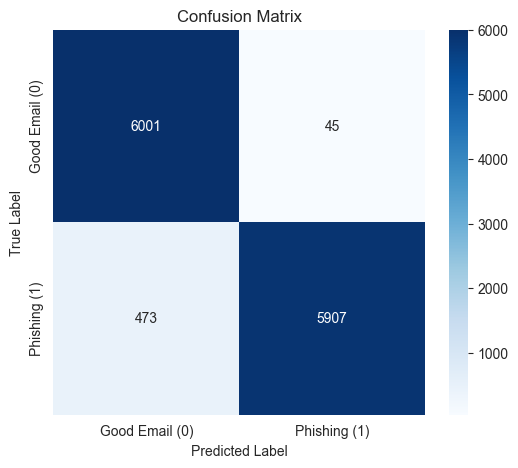

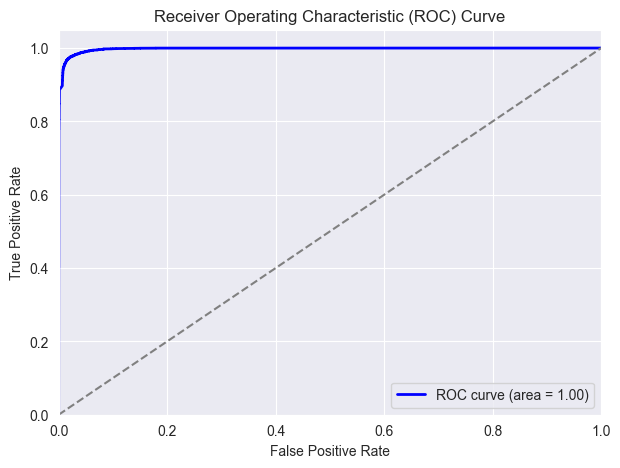

Sender Contribution: 0.1162524961940384
Subject Contribution: 0.03530358388950726
Body Contribution: 0.8484439199164543
Total Contribution: 11198361.216068264


In [40]:
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# Compute sum of absolute log probabilities for each feature category
sender_importance = np.sum(np.abs(nb_model.feature_log_prob_[:, :X_sender.shape[1]]))
subject_importance = np.sum(np.abs(nb_model.feature_log_prob_[:, X_sender.shape[1]:X_sender.shape[1] + X_subject.shape[1]]))
body_importance = np.sum(np.abs(nb_model.feature_log_prob_[:, X_sender.shape[1] + X_subject.shape[1]:]))

total_importance = sender_importance + subject_importance + body_importance

print("Sender Contribution:", sender_importance / total_importance)
print("Subject Contribution:", subject_importance / total_importance)
print("Body Contribution:", body_importance / total_importance)
print("Total Contribution:", total_importance)

Test Accuracy: 0.9047619047619048
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.50      0.67         4

    accuracy                           0.90        21
   macro avg       0.95      0.75      0.81        21
weighted avg       0.91      0.90      0.89        21



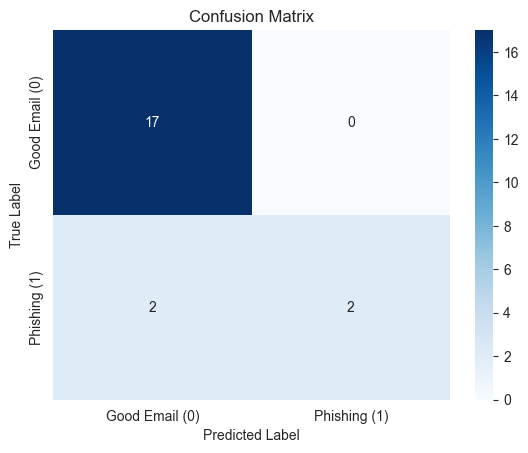

In [41]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = nb_model.predict(X_test_combined)
test_df['phishing_probability'] = nb_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

Random Forest

Accuracy: 0.9739256397875422
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      6046
           1       0.99      0.96      0.97      6380

    accuracy                           0.97     12426
   macro avg       0.97      0.97      0.97     12426
weighted avg       0.97      0.97      0.97     12426



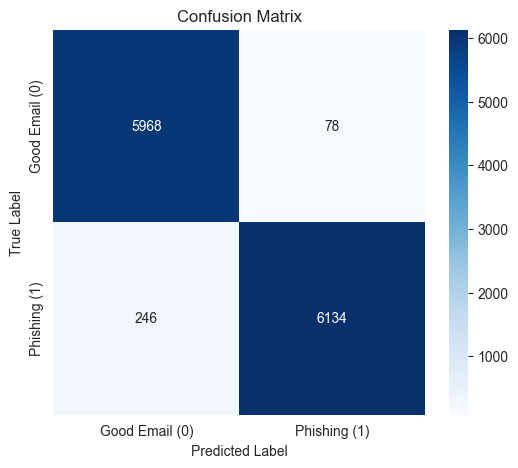

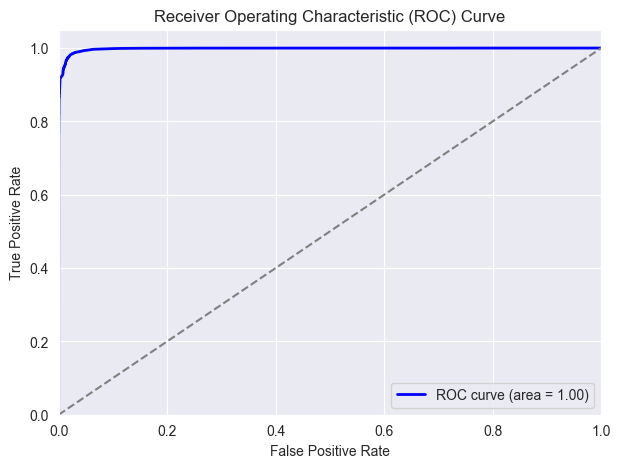

In [42]:
from sklearn.ensemble import RandomForestClassifier
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train Random Forest Model, trees=50
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       0.25      0.25      0.25         4

    accuracy                           0.71        21
   macro avg       0.54      0.54      0.54        21
weighted avg       0.71      0.71      0.71        21



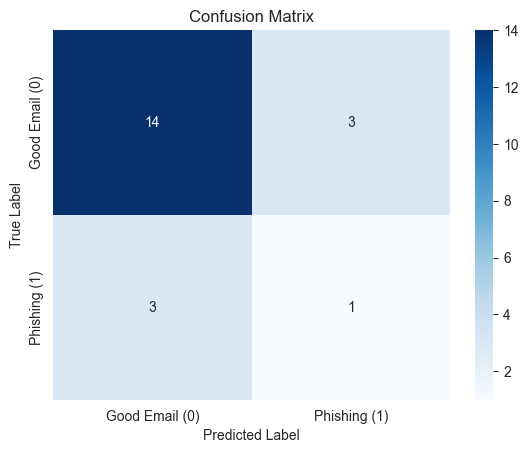

In [43]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = rf_model.predict(X_test_combined)
test_df['phishing_probability'] = rf_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


xgboost

C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:45:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9788347014324803
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      6046
           1       0.97      0.99      0.98      6380

    accuracy                           0.98     12426
   macro avg       0.98      0.98      0.98     12426
weighted avg       0.98      0.98      0.98     12426



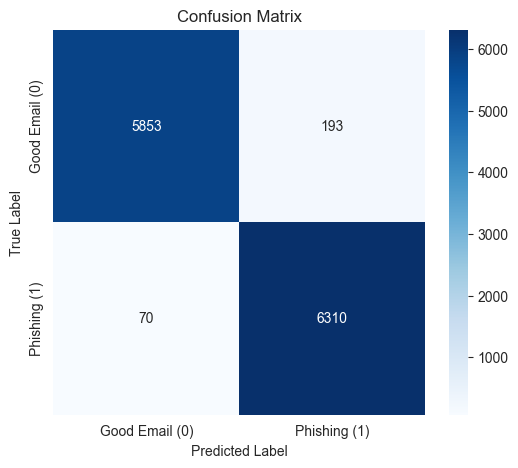

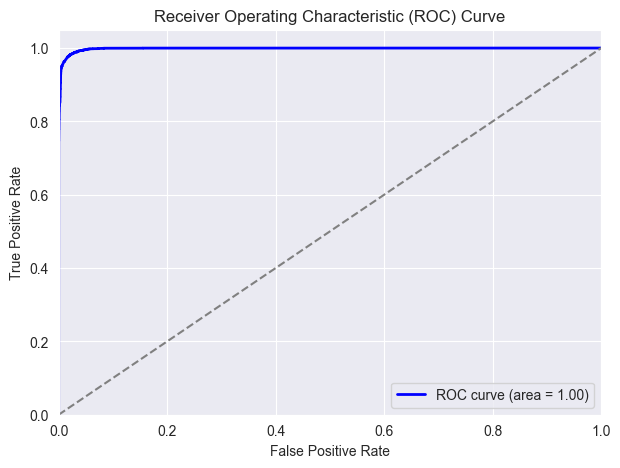

In [44]:
from xgboost import XGBClassifier
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train XGBoost Model, disable the internal label encoder and avoid any related warnings or errors, logarithmic loss for classification problems
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8095238095238095
              precision    recall  f1-score   support

           0       0.93      0.82      0.88        17
           1       0.50      0.75      0.60         4

    accuracy                           0.81        21
   macro avg       0.72      0.79      0.74        21
weighted avg       0.85      0.81      0.82        21



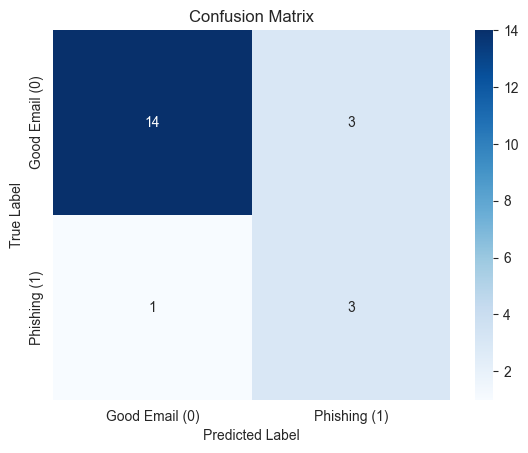

In [45]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = xgb_model.predict(X_test_combined)
test_df['phishing_probability'] = xgb_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

Logistic Regression

Accuracy: 0.9876871076774505
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      6046
           1       0.98      0.99      0.99      6380

    accuracy                           0.99     12426
   macro avg       0.99      0.99      0.99     12426
weighted avg       0.99      0.99      0.99     12426



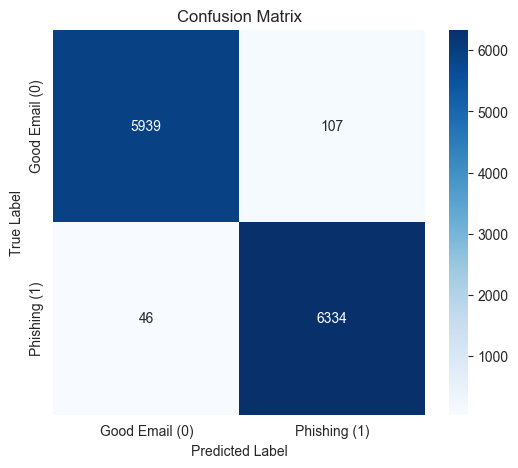

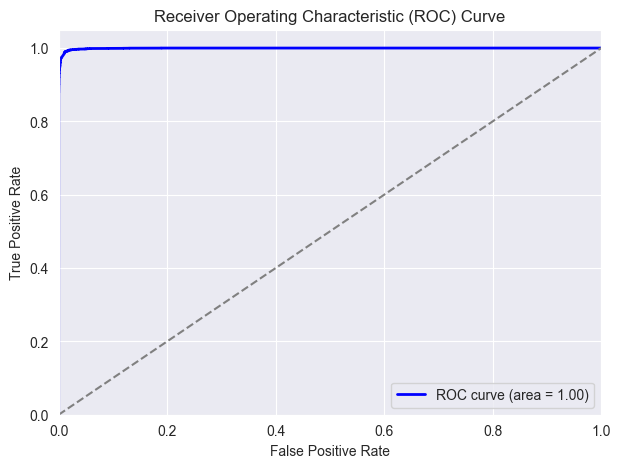

In [46]:
from sklearn.linear_model import LogisticRegression
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Predictions
y_pred = logreg_model.predict(X_test)
y_pred_proba = logreg_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6190476190476191
              precision    recall  f1-score   support

           0       0.85      0.65      0.73        17
           1       0.25      0.50      0.33         4

    accuracy                           0.62        21
   macro avg       0.55      0.57      0.53        21
weighted avg       0.73      0.62      0.66        21



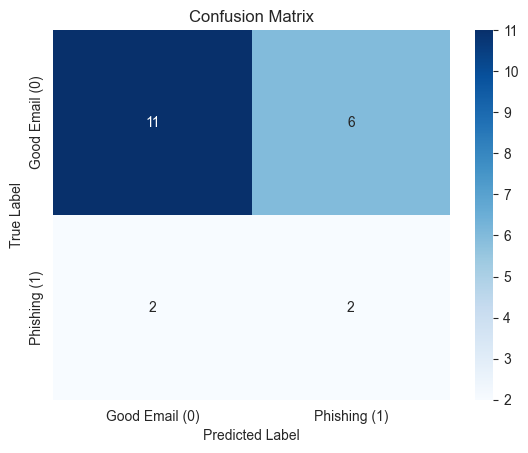

In [47]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = logreg_model.predict(X_test_combined)
test_df['phishing_probability'] = logreg_model.predict_proba(X_test_combined)[:, 1]

if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

K-Nearest Neighbors

Accuracy: 0.9147754707870593
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      6046
           1       0.92      0.91      0.92      6380

    accuracy                           0.91     12426
   macro avg       0.91      0.91      0.91     12426
weighted avg       0.91      0.91      0.91     12426



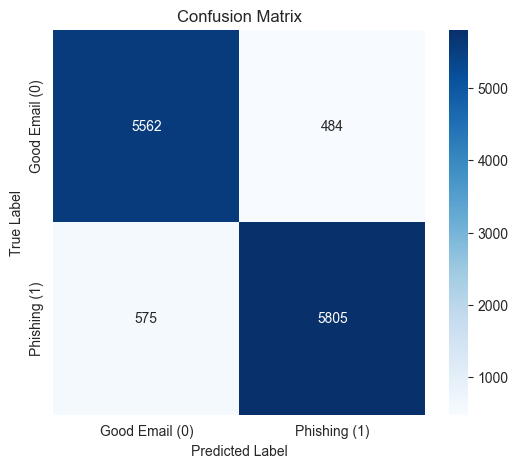

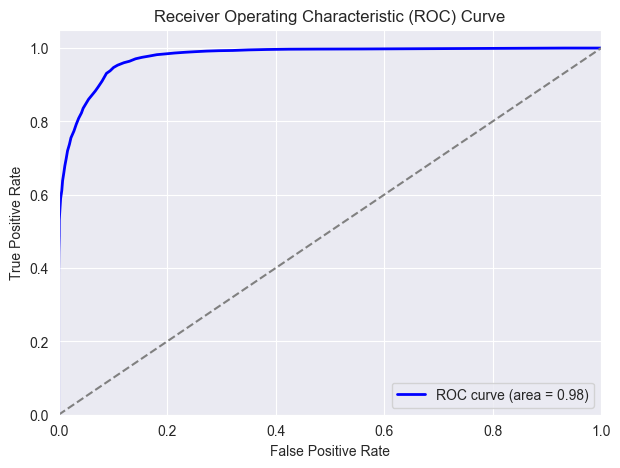

In [48]:
from sklearn.neighbors import KNeighborsClassifier
# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

#  consider the 25 nearest neighbors when determining the class of a new data point
knn_model = KNeighborsClassifier(n_neighbors=50)
knn_model.fit(X_train, y_train)

# Predictions
y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.5238095238095238
              precision    recall  f1-score   support

           0       1.00      0.41      0.58        17
           1       0.29      1.00      0.44         4

    accuracy                           0.52        21
   macro avg       0.64      0.71      0.51        21
weighted avg       0.86      0.52      0.56        21



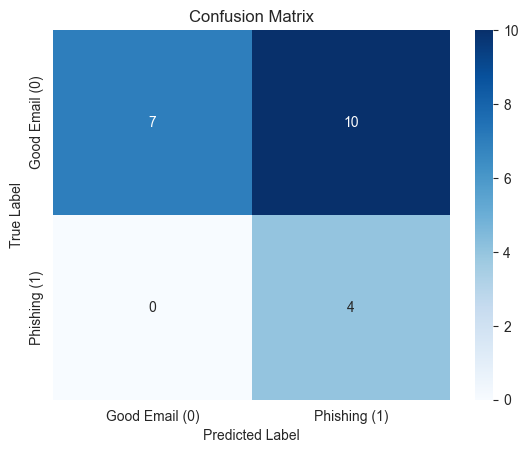

In [49]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = knn_model.predict(X_test_combined)
test_df['phishing_probability'] = knn_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

AdaBoost

Accuracy: 0.8540157733784002
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      6046
           1       0.83      0.91      0.86      6380

    accuracy                           0.85     12426
   macro avg       0.86      0.85      0.85     12426
weighted avg       0.86      0.85      0.85     12426



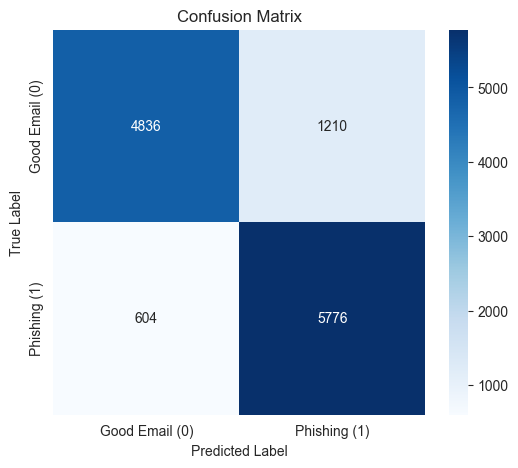

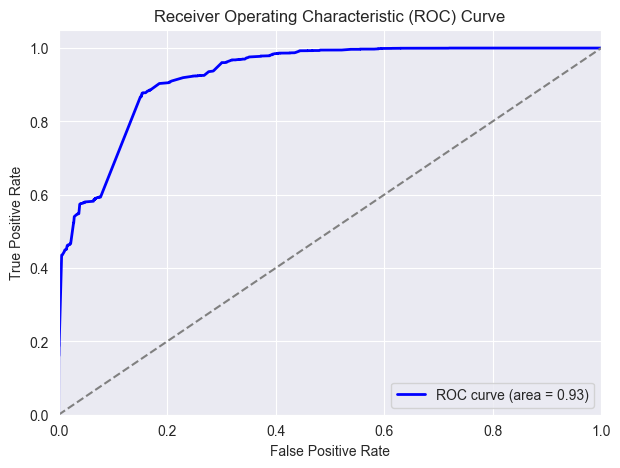

In [50]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# DecisionTreeClassifier with max_depth=1 (weak learner), tree size =50
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# Predictions
y_pred = ada_model.predict(X_test)
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.38      0.75      0.50         4

    accuracy                           0.71        21
   macro avg       0.65      0.73      0.65        21
weighted avg       0.82      0.71      0.74        21



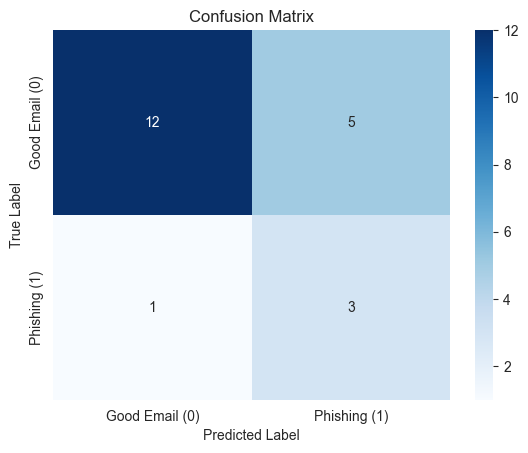

In [51]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
test_df['predicted_label'] = ada_model.predict(X_test_combined)
test_df['phishing_probability'] = ada_model.predict_proba(X_test_combined)[:, 1]


if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Show results
#print(test_df[['sender', 'subject', 'predicted_label', 'phishing_probability']].head())

# Save results with predictions
#test_df.to_excel(".xlsx", index=False)

Stacking Classifier

In [66]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
base_models = [
    ('nb', MultinomialNB()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('ada', AdaBoostClassifier(n_estimators=50, random_state=42))
]

# Define meta-model
meta_model = LogisticRegression()

# Create Stacking Classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train Stacking model
stacking_model.fit(X_train, y_train)

# Predictions
y_pred_stack = stacking_model.predict(X_test)

# Evaluate Performance
print("Stacking Model Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacking Model Classification Report:\n", classification_report(y_test, y_pred_stack))

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Voting Classifier')
plt.show()

C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:13:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:11:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:12:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

Stacking Model Accuracy: 0.9891356832448093
Stacking Model Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6046
           1       0.99      0.99      0.99      6380

    accuracy                           0.99     12426
   macro avg       0.99      0.99      0.99     12426
weighted avg       0.99      0.99      0.99     12426



ValueError: Found input variables with inconsistent numbers of samples: [12426, 21]

voting

In [ ]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
y_pred = stacking_model.predict(X_test_combined)

# Store predictions in the dataframe
test_df['predicted_label'] = y_pred

# Evaluate Performance
if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Compute and Plot Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'],
                yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


C:\Users\may\PycharmProjects\ML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:26:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Accuracy: 0.9882504426203123
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6046
           1       0.99      0.99      0.99      6380

    accuracy                           0.99     12426
   macro avg       0.99      0.99      0.99     12426
weighted avg       0.99      0.99      0.99     12426



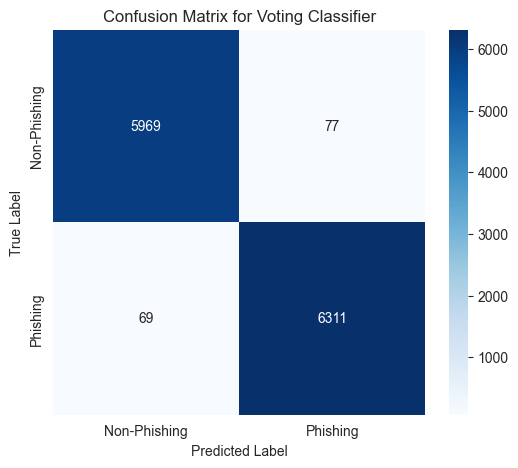

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier

# Define base models
nb_model = MultinomialNB()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can tune 'n_neighbors'
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Create Voting Classifier with all models
ensemble_model = VotingClassifier(
    estimators=[('nb', nb_model), ('rf', rf_model), ('xgb', xgb_model), ('knn', knn_model), ('ada', ada_model)],
    voting='soft'  # 'soft' voting uses probabilities, 'hard' voting uses majority class
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Predictions
y_pred = ensemble_model.predict(X_test)

# Evaluate Performance
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("Ensemble Classification Report:\n", classification_report(y_test, y_pred))

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix  for Voting Classifier')
plt.show()

Test Accuracy: 0.8095238095238095
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       0.50      0.50      0.50         4

    accuracy                           0.81        21
   macro avg       0.69      0.69      0.69        21
weighted avg       0.81      0.81      0.81        21



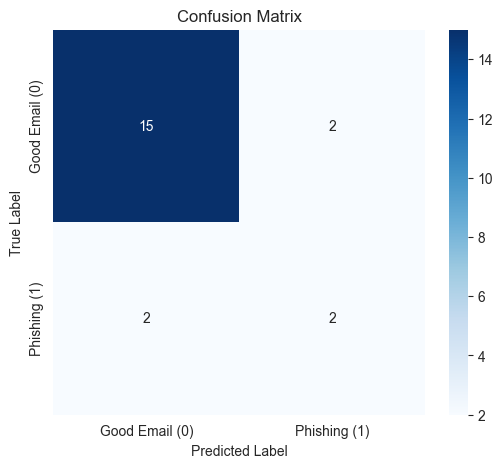

In [65]:
# Load test data
test_df = pd.read_excel(r"C:\Users\may\Desktop\phishing.xlsx")

# Preprocess test data (same cleaning as training)
test_df['cleaned_sender'] = test_df['sender'].apply(clean_text)
test_df['cleaned_subject'] = test_df['subject'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

# Transform using existing vectorizers
X_test_sender = tfidf_sender.transform(test_df['cleaned_sender'])
X_test_subject = tfidf_subject.transform(test_df['cleaned_subject'])
X_test_body = tfidf_body.transform(test_df['cleaned_body'])

# Combine features
X_test_combined = hstack((X_test_sender, X_test_subject, X_test_body))

# Make predictions
y_pred = ensemble_model.predict(X_test_combined)

# Store predictions in the dataframe
test_df['predicted_label'] = y_pred

# Evaluate Performance
if 'label' in test_df.columns:
    print("Test Accuracy:", accuracy_score(test_df['label'], test_df['predicted_label']))
    print(classification_report(test_df['label'], test_df['predicted_label']))

    # Compute and Plot Confusion Matrix
    cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'],
                yticklabels=['Good Email (0)', 'Phishing (1)'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
